# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage as ski


In [7]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print(X_train.shape)
print(y_test.shape)

(39209, 32, 32, 3)
(12630,)


In [8]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Number of columns 4
Number of rows 10


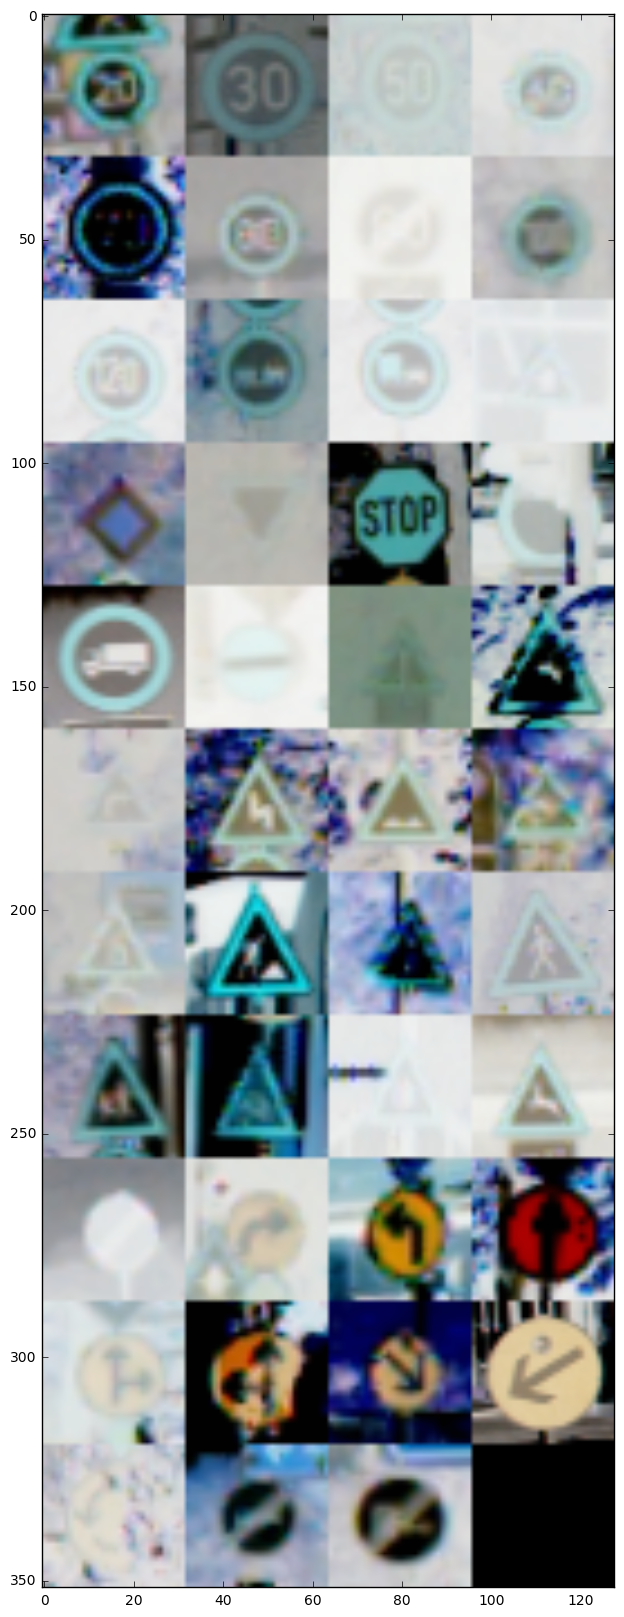

In [9]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

## VIEW SUMMARY OF TYPES OF IMAGES BEING CLASSIFIED
num_cols = 4
num_rows = int(n_classes/4.0)
print("Number of columns",num_cols)
print("Number of rows", num_rows)

img_ix = [np.amin(np.where(y_train==x)) for x in np.unique(y_train)]

all_imgs = [[None]*num_cols]*(num_rows+1)
all_imgs = np.empty(((num_rows+1)*32, num_cols*32, 3))
i=1
row_ix = 0
col_ix = 0
#fig = plt.figure()
for img in img_ix:
    row_start = row_ix*32
    row_end = row_start + 32
    col_start = col_ix*32
    col_end = col_start + 32
   # print(row_start, row_end, col_start, col_end)
    all_imgs[row_start:row_end, col_start:col_end, 0:3] = X_train[img]
    #all_imgs[row_ix][col_ix] = X_train[img]
    if col_ix==3:
        row_ix = row_ix + 1
        col_ix = 0
    else:
        col_ix = col_ix + 1
    
#plt.imshow(all_imgs)
dpi=80
xpixels = 1624
ypixels = 600
fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
plt.imshow(all_imgs)
plt.show()


1


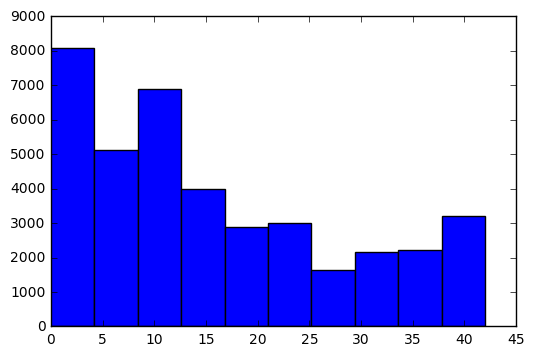

In [10]:
# VIEW HISTOGRAM OF TRAINING CLASSES

print(y_train[1000])
plt.hist(y_train)
plt.show()


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

from sklearn import pipeline as skpipe
from skimage import color
#color conversion
def to_grayscale(img):
    return color.rgb2gray(img)

def to_yuv(img):
    return color.rgb2hsv(img)

def standardize_image(img):
    #assume grayscale only for now
    img = (img - np.mean(img)) / np.std(img)
    return img

#preprocess_pipe = [to_grayscale, standardize_image]
preprocess_pipe = [to_grayscale]

def preprocess_img(proc_img):
    for func in preprocess_pipe:
        proc_img = func(proc_img)
    return proc_img


In [12]:
#preprocess images using the preprocessing pipeline

single_proc = preprocess_img(X_train[0])
single_image_shape = single_proc.shape

# preprocess training set
final_shape = (X_train.shape[0],) + single_image_shape
X_train_proc = np.empty(final_shape)
for i in range(0, X_train.shape[0]):
    X_train_proc[i,:,:] = preprocess_img(X_train[i,:,:,:])

# preprocess test set
final_shape = (X_test.shape[0],) + single_image_shape
X_test_proc = np.empty(final_shape)
for i in range(0, X_test.shape[0]):
    X_test_proc[i,:,:] = preprocess_img(X_train[i,:,:,:])



(12630, 32, 32)


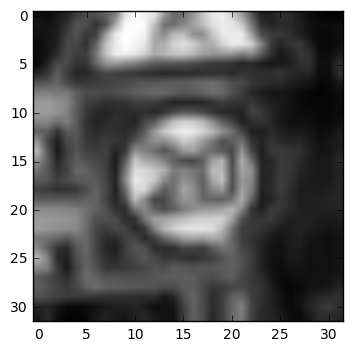

In [13]:
print(X_test_proc.shape)
plt.imshow(X_train_proc[0],cmap='gray')
plt.show()

In [14]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train, y_train, test_size=0.20, random_state=42)


In [15]:
import random
from sklearn import preprocessing
### Define your architecture here.
### Feel free to use as many code cells as needed.

# setup helper function to get batch

def get_batch_idxs(train_set_length, batch_size):
    #first shuffle all ix
    print("train_set lenght: ", train_set_length)
    print("batch_size: ", batch_size)
    rand_idx = list(range(0, train_set_length-1))
    random.shuffle(rand_idx)
    result = [(i,i+batch_size) for i in range(0,len(rand_idx)-batch_size,batch_size)]
    return [rand_idx, result]

def get_serial_batch_idxs(train_set_length, batch_size):
    result = [(i,i+batch_size) for i in range(0,(train_set_length)-batch_size,batch_size)]
    return result

def one_hot_encode(y_data, n_classes):
    ohc = preprocessing.OneHotEncoder()
    y_ohc = ohc.fit(np.arange(n_classes).reshape(-1, 1))
    y_labels = y_ohc.transform(y_data.reshape(-1, 1)).toarray()
    return y_labels
   

In [16]:
# Parameters
learning_rate = 0.01
batch_size = 128
training_epochs = 15

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

# Store layers weight & bias
weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 3, layer_width['layer_1']], stddev=0.01)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']], stddev=0.01)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']],stddev=0.01)),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [8192, layer_width['fully_connected']],stddev=0.01)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes],stddev=0.01))
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

# Create model
def conv_net(x, weights, biases):
    #image = tf.reshape(x, [-1,32,32,1])
    # Layer 1
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)

#     # Layer 2
#     conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
#     conv2 = maxpool2d(conv2)

#     # Layer 3
#     conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
#     conv3 = maxpool2d(conv3)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv1,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)

    # Output Layer - class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# tf Graph input
x = tf.placeholder("float", [None, single_image_shape[0], single_image_shape[1],3])
y = tf.placeholder("float", [None, n_classes])

logits = conv_net(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer()\
    .minimize(cost)


In [17]:
ix_list = [1,4,5,6]
print(X_train[ix_list].shape)
print(X_train_s[1:10000].shape[0])
batch_idx_list = get_serial_batch_idxs(X_train_s[1:5000].shape[0], batch_size)        # Loop over all batches
print(batch_idx_list)   

print(y_train_s[0:5])
print(np.where(one_hot_encode(y_train_s[0:5],n_classes)))

(4, 32, 32, 3)
9999
[(0, 128), (128, 256), (256, 384), (384, 512), (512, 640), (640, 768), (768, 896), (896, 1024), (1024, 1152), (1152, 1280), (1280, 1408), (1408, 1536), (1536, 1664), (1664, 1792), (1792, 1920), (1920, 2048), (2048, 2176), (2176, 2304), (2304, 2432), (2432, 2560), (2560, 2688), (2688, 2816), (2816, 2944), (2944, 3072), (3072, 3200), (3200, 3328), (3328, 3456), (3456, 3584), (3584, 3712), (3712, 3840), (3840, 3968), (3968, 4096), (4096, 4224), (4224, 4352), (4352, 4480), (4480, 4608), (4608, 4736), (4736, 4864), (4864, 4992)]
[36 28  2  5 26]
(array([0, 1, 2, 3, 4]), array([36, 28,  2,  5, 26]))


In [18]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Test model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))    

# Initializing the variables
init = tf.initialize_all_variables()

saver = tf.train.Saver()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        batch_idx_list = get_serial_batch_idxs(X_train_s.shape[0], batch_size)        # Loop over all batches
        for i in batch_idx_list:
            batch_start = i[0]
            batch_end = i[1]
            batch_x = X_train_s[batch_start:batch_end]
            batch_y = y_train_s[batch_start:batch_end]
            batch_y = one_hot_encode(batch_y, n_classes)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
        train_accuracy = accuracy.eval(feed_dict={
                              x:X_valid_s, y: one_hot_encode(y_valid_s,n_classes)})
        print("batch training accuracy %g"%(train_accuracy))
        test_accuracy = accuracy.eval(feed_dict={
                              x:X_test, y: one_hot_encode(y_test,n_classes)})
        print("batch testing accuracy %g"%(test_accuracy))
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    saver.save(sess, './trained_model.chkp')
    print("Optimization Finished!")


Instructions for updating:
Use `tf.global_variables_initializer` instead.
batch training accuracy 0.93114
batch testing accuracy 0.843943
Epoch: 0001 cost= 0.213808745
batch training accuracy 0.940194
batch testing accuracy 0.857641
Epoch: 0002 cost= 0.148158014
batch training accuracy 0.946187
batch testing accuracy 0.857087
Epoch: 0003 cost= 0.053967029
batch training accuracy 0.948865
batch testing accuracy 0.871497
Epoch: 0004 cost= 0.043294571
batch training accuracy 0.973987
batch testing accuracy 0.900713
Epoch: 0005 cost= 0.016916292
batch training accuracy 0.953966
batch testing accuracy 0.856928
Epoch: 0006 cost= 0.058909439
batch training accuracy 0.972074
batch testing accuracy 0.894854
Epoch: 0007 cost= 0.010243403
batch training accuracy 0.969141
batch testing accuracy 0.887411
Epoch: 0008 cost= 0.012258088
batch training accuracy 0.974242
batch testing accuracy 0.892795
Epoch: 0009 cost= 0.008209743
batch training accuracy 0.96251
batch testing accuracy 0.871972
Epoch: 0

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

I began by preprocessing the data using rgb to grayscale conversion followed by standardization of images to 0 mean and unit standard deviation. This yielded poor results. Ultimately, I decided that the network should be able to learn the preprocessing steps and therefore fed directly the RGB values. Indeed this approach worked and I therefore skipped my preprocessing steps and directly worked on RGB images. 

Since the CNN is essentially learning how to extract features and process the image prior to classification by learning kernels and obtaining kernel responses, it seems more straightforward and better to let the network learn the preprocessing steps itself. In a sense the network can prepare the data for it's own classification. On the other hand the correct preprocessing prior to input to the network may lead to quicker convergence since  

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I split the training set into a training and validation set with 20% samples going to validation set. The testset remained a truely out of sample test set used for testing. During each epoch I displayed the validation and test set accuracy to monitor progress of the network. 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I used a CNN with 32 5x5x3 kernels in one convolutional layer followed by a fully connected layer consisting of 8192 units. This simple architecture yielded over 85% accuracy on the test and was fairly easy to train. More complex models took a much longer time to train. Given the trade off of time to train vs accuracy I chose the simple 1 layer network which was easy to iterate on in terms of other hyperparameters while still yielding a high test accuracy.   



### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Optimizer: AdamOptimizer which is modern and can manage to train without providing defaults for learning rate and other parameters. 

Batch Size: 128

Epochs: 15

Single layer neural net with 32 units with 5x5x3 Kernels and one fully connected layer with 8192 units. Relus are used through out the network.  

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

To begin with the traffic sign problem is very similar to the MNIST problem of classifying images under various transforms, translations and lighting conditions. Since this type of problem requires image processing and the detection of image features a CNN seemed to be the correct approach. A CNN can be built from one or more convolutional layers and is typically followed by a fully connected layer. Since traffic signs may not vary too much in shape, size and appearance the problem is more about capturing the variations introduced by scene capture condition e.g. lighting etc. This would motivate one to reduce to an architecture of fewer layers and at the lower end a single convolutional layer which is what I chose. 

After experimenting with a few optimizers e.g. GradientDescentOptimizer, AdagradOptimzer I found that the AdamOptimizer eliminated the need for choosing a learning rate and took care of momentum too. In practice it was also the fastest. This reduced the number of hyperparameters to be tuned. For the other parameters I chose the largest batch size that would not result in a out of memory error on the machine. A large batch leads to more stable results in general over the course of training. 

Training occured over 15 epochs, I began with 5 epochs to make sure things were working before increasing the number of epochs. Since training is fairly time consuming for practical considerations I conservatively increased the number of epochs until the validation accuracy was over 90%. The test accuracy tends to be a little lower than validation accuracy and this is what I observed in my experiments as well. However, after 90% accuracy is crossed on the validation set the test set accuracy is also fairly high and very near 90% too. 


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

5


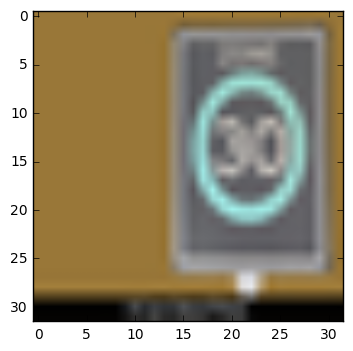

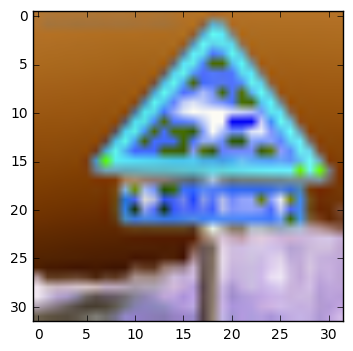

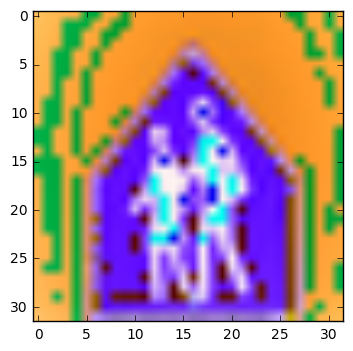

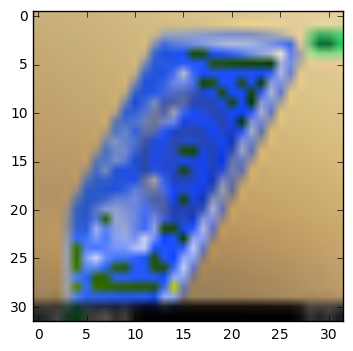

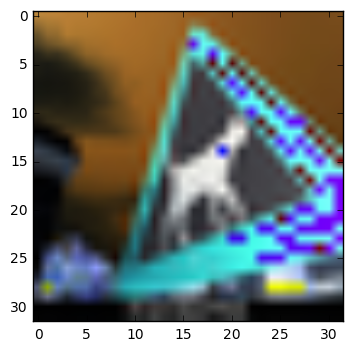

In [23]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import glob
from scipy import ndimage
import PIL
from PIL import Image

extra_dirname='data/extra/*'
files = glob.glob(extra_dirname)
print(len(files))

new_images = np.empty((len(files),32,32,3))
i=0
for f in files:
        a = Image.open(f)
        a = a.resize((32,32), PIL.Image.ANTIALIAS)
        new_images[i,:,:,:] = a
        plt.imshow(new_images[i])
        i = i + 1
        plt.show()
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [24]:
import pandas as pd
signames = pd.read_csv('signnames.csv')
signames.head()
print(signames.loc[0,'SignName'])


Speed limit (20km/h)


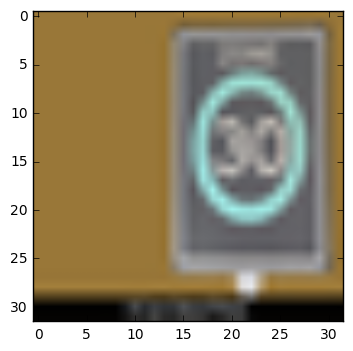

NN predicted 12
12    Priority road
Name: SignName, dtype: object


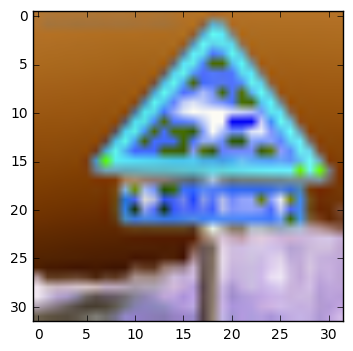

NN predicted 12
12    Priority road
Name: SignName, dtype: object


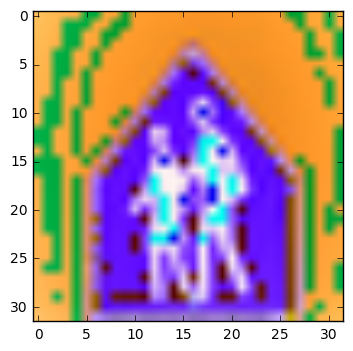

NN predicted 25
25    Road work
Name: SignName, dtype: object


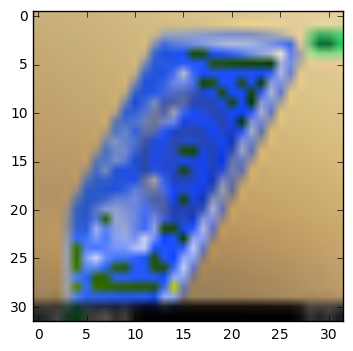

NN predicted 25
25    Road work
Name: SignName, dtype: object


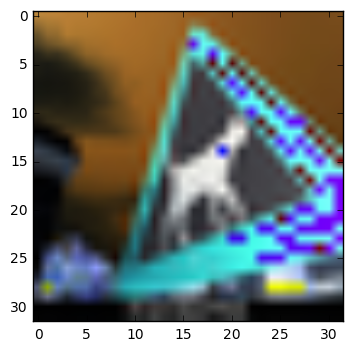

NN predicted 11
11    Right-of-way at the next intersection
Name: SignName, dtype: object


In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

signames = pd.read_csv('signnames.csv')
signames.head()
with tf.Session() as sess:
    saver.restore(sess, './trained_model.chkp')
    
    classification = sess.run(tf.argmax(logits, 1), feed_dict={x: new_images})
    for i in range(0, new_images.shape[0]):
        plt.imshow(new_images[i])
        plt.show()
        print ('NN predicted', classification[i])
        print(signames.loc[signames['ClassId']==classification[i],'SignName'])

TopKV2(values=array([[  9.38421726e-01,   6.00451007e-02,   1.53316918e-03],
       [  9.99998093e-01,   1.94639733e-06,   7.40047780e-12],
       [  1.00000000e+00,   7.91500970e-28,   1.86919356e-38],
       [  1.00000000e+00,   5.75605752e-13,   6.64179546e-24],
       [  1.00000000e+00,   6.45671023e-15,   7.14076576e-23]], dtype=float32), indices=array([[12,  6,  1],
       [12, 10, 17],
       [25, 11, 24],
       [25, 17, 12],
       [11,  3,  1]], dtype=int32))
43
[  1.36314283e-14   1.53316918e-03   5.04683714e-34   3.61199085e-18
   4.30475906e-23   7.30504979e-12   6.00451007e-02   1.69650474e-28
   0.00000000e+00   4.81711581e-29   1.59880773e-30   1.85490781e-26
   9.38421726e-01   0.00000000e+00   4.06510965e-21   3.80396845e-38
   3.55072726e-36   6.26579026e-19   5.51048777e-25   2.84481038e-27
   2.78264743e-25   6.39273108e-28   0.00000000e+00   3.71757847e-31
   5.60793872e-22   1.12429749e-14   1.19148144e-32   4.04527073e-32
   8.09380440e-24   1.64217413e-32   1.7

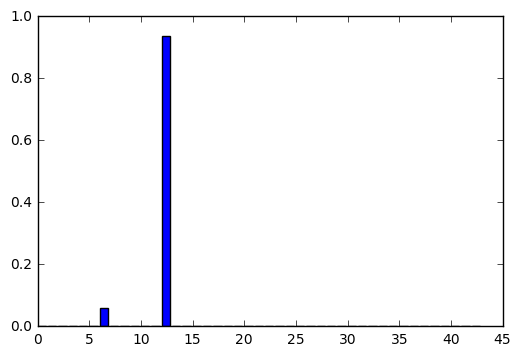

43
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   4.53362916e-29
   0.00000000e+00   1.99233006e-18   0.00000000e+00   2.76491976e-30
   0.00000000e+00   1.72259385e-33   1.94639733e-06   0.00000000e+00
   9.99998093e-01   1.84228989e-38   1.34876738e-25   6.75134457e-24
   0.00000000e+00   7.40047780e-12   0.00000000e+00   3.45740877e-36
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.91105298e-21   2.21694806e-18   0.00000000e+00
   0.00000000e+00   1.13121759e-34   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


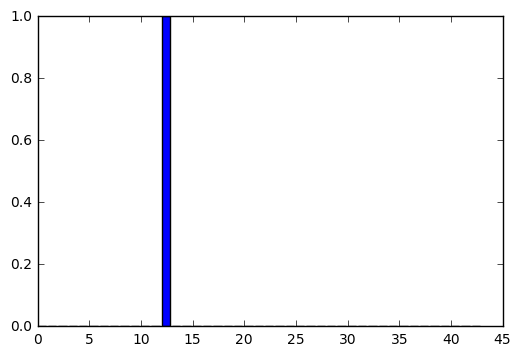

43
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   7.91500970e-28
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.86919356e-38   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


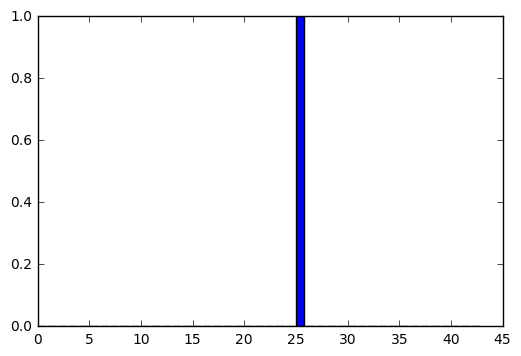

43
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.91737328e-28   7.79931271e-29   0.00000000e+00
   6.64179546e-24   3.70990653e-26   1.33308297e-38   0.00000000e+00
   0.00000000e+00   5.75605752e-13   0.00000000e+00   1.44770546e-30
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   3.73345479e-36   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.36992255e-38
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]


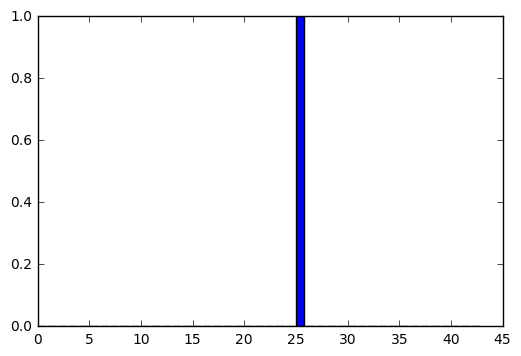

43
[  0.00000000e+00   7.14076576e-23   0.00000000e+00   6.45671023e-15
   0.00000000e+00   1.10844086e-31   2.57917312e-28   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.93462818e-26   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.64214136e-32   0.00000000e+00   3.03012962e-28
   0.00000000e+00   1.09886599e-33   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   7.38941845e-31
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.01289651e-29   3.03756336e-33]


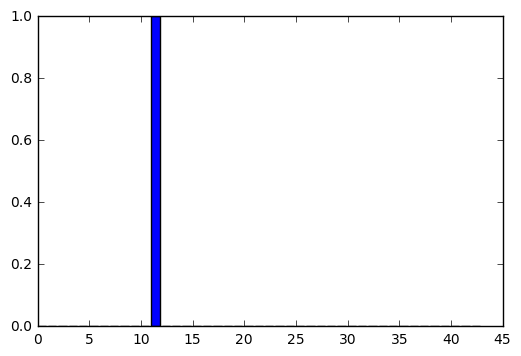

In [26]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

smax_prob = tf.nn.softmax(logits)
top_k_op = tf.nn.top_k(smax_prob, 3)
with tf.Session() as sess:
    saver.restore(sess, './trained_model.chkp')
    
    classification = sess.run(smax_prob, feed_dict={x: new_images})
    top_k = sess.run(top_k_op, feed_dict={smax_prob: classification})
    print(top_k)
    for probs in classification:
        print(len(probs))
        print(probs)
        plt.bar(range(43), probs)
        plt.show()

        

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

The model does fairly poorly on the new set of images. While one sign I chose is a speed limit sign the others are not really part of one of the classes. I chose some of those images to see how close it would get to an actual sign e.g. by matching just the shape of the sign or the color. This seemed to work fairly poorly and the model did not really match signs based on shape. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


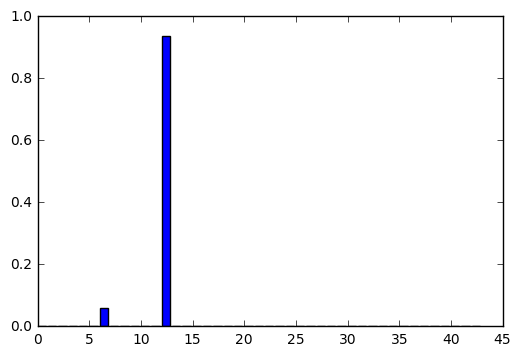

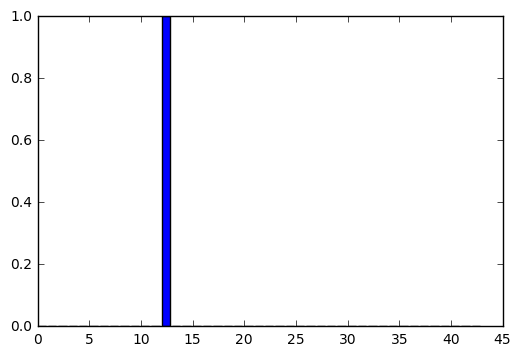

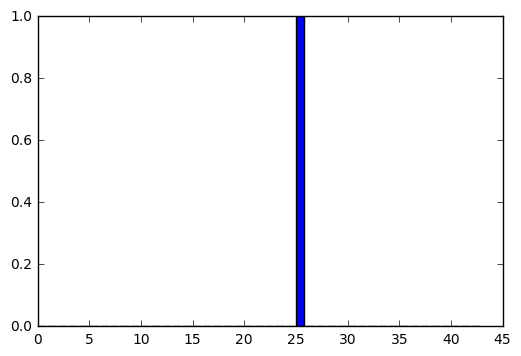

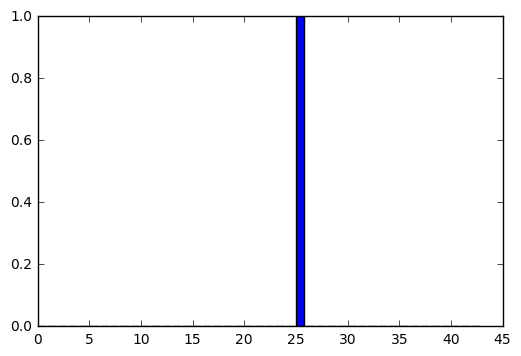

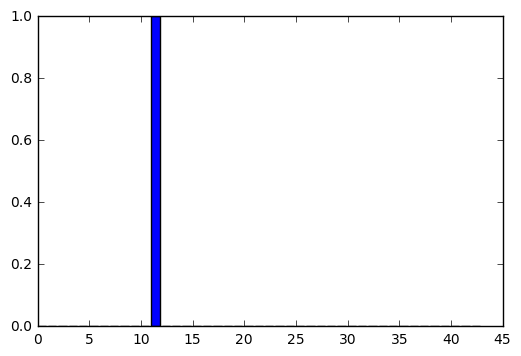

In [28]:
with tf.Session() as sess:
    saver.restore(sess, './trained_model.chkp')
    
    classification = sess.run(smax_prob, feed_dict={x: new_images})
    top_k = sess.run(top_k_op, feed_dict={smax_prob: classification})
    for probs in classification:
        plt.bar(range(43), probs)
        plt.show()



**Answer:**

TopKV2(values=array([[  9.99999881e-01,   7.15186061e-08,   4.51084690e-11],
       [  1.00000000e+00,   9.12866023e-21,   1.29776035e-21],
       [  9.99776423e-01,   2.23528841e-04,   1.62085873e-10],
       [  9.28738356e-01,   7.12616593e-02,   1.59178486e-11],
       [  9.99993563e-01,   6.41447241e-06,   2.24357261e-28]], dtype=float32)
       
If we look at the output from nn.top_k interestingly the network is quite certain about each of it's decisions. However, the values are not correct. We have challenged the network by giving it some signs it has never seen but there seems to be a high certainity even though it doesnt have the answer quite right. 


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.